# 8. Generative Deep Learning

### DeepDream

Deepdream is an artistic image modification technique that uses the representations learnt by CNN. It was released by Google in 2015.

The DeepDream algorithm is almost identical to the convnet filter-visualisation technique, consisting of running a convnet in reverse, doing gradient ascent on teh input to the convnet in order to maximise the activation of a specific filter in an upper layer of the convnet. Some key differences are:

1. With DeepDream, you try to maximise the activation of entire layers rather than that of a specific filter, thus mixing together visualisations of learge number of features at once

2. You start from an existing image - thus the resulting effects latch on to preexisting visual patterns, distorting elements of the image

3. The input images are processed at different scales (called octaves) which improves the quality of the visualisations


To begin, we load a convnet pretrained in ImageNet. We will be using the convnet in the original DeepDream release, which is an Inception model.

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
K = tf.keras.backend
import PIL.Image
import IPython.display as display

%tensorflow_version 2.x
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
def normalise_img(img):
    img = 255*(img+1.0) / 2.0
    return tf.cast(img, tf.uint8)

def show(img):
    display.display(PIL.Image.fromarray(np.array(img)))    

In [3]:
HOME_DIR = os.path.dirname(os.path.abspath('__FILE__'))
WORKSPACE_DIR = os.path.join(HOME_DIR, 'sample_data')
fn = os.path.join(WORKSPACE_DIR, '3408.jpg')

oimg = tf.keras.preprocessing.image.load_img(fn)
img_array = tf.keras.preprocessing.image.img_to_array(oimg)

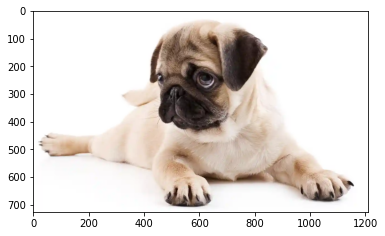

In [4]:
# Show Image
plt.imshow(oimg)

In [5]:
# Instantiate model
###################
base_model = tf.keras.applications.inception_v3.InceptionV3(weights='imagenet', include_top=False)

Next, we compute the loss - the quantity you'll seek to maximise during the gradient-ascent algorithm. Here, we will simultaneously maximize the activation of all filters in a number of layers. Specifically we will maximise a weighted sum of the L2 norm of the activations of a set of high level layers. The exact set of layers you choose (as well as their contribution to the final loss) has a major influence on the visuals you'll be able to produce, so you want to make these parameters easily configurable.

In [6]:
layer_contribs = {
    'mixed3' : 3., 'mixed5' : 1.5,
}
# dict to map a layer name to its instance
layers = [base_model.get_layer(name).output for name in list(layer_contribs)]

dreamer = tf.keras.Model(inputs = base_model.input, outputs = layers)

Define a tensor that contains the loss: the weighted sum of the L2 norm of the activations of the layers.

In [7]:
def calc_loss(img, model):
    img_batch = tf.expand_dims(img, axis=0)
    layer_activations = model(img_batch)
    if len(layer_activations) == 1:
        layer_activations = [layer_activations]
        
    losses = []
    for a in layer_activations:
        loss = tf.math.reduce_mean(a)
        losses.append(loss)
    return tf.reduce_sum(losses)

In [8]:
class DeepDream(tf.Module):
    def __init__(self, model):
        self.model = model
    @tf.function(
    input_signature=(
        tf.TensorSpec(shape=[None, None, 3], dtype=tf.float32),
        tf.TensorSpec(shape=[], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.float32),))
    
    def __call__(self, img, steps, step_size):
        print("Tracing")
        loss = tf.constant(0.0)
        for n in tf.range(steps):
            with tf.GradientTape() as tape:
                tape.watch(img)
                loss = calc_loss(img, self.model)
            gradients = tape.gradient(loss, img)

            gradients /= tf.math.reduce_std(gradients) + 1e-8

            img = img + gradients * step_size
            img = tf.clip_by_value(img, -1, 1)
        return loss, img

In [9]:
deepdream = DeepDream(dreamer)

In [10]:
def run_deep_dream_simple(img, steps=100, step_size=0.01):
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    img = tf.convert_to_tensor(img)
    step_size = tf.convert_to_tensor(step_size)
    steps_remaining = steps
    step = 0
    
    while steps_remaining:
        if steps_remaining > 100:
            run_steps = tf.constant(100)
        else:
            run_steps = tf.constant(steps_remaining)
        
        steps_remaining -= run_steps
        step += run_steps
        
        loss, img = deepdream(img, run_steps, tf.constant(step_size))
        
        display.clear_output(wait=True)
        show(normalise_img(img))
        print("Step: " + str(step))
        print("Loss: " + str(loss))  
    result = normalise_img(img)
    display.clear_output(wait=True)
    show(result)
    return result

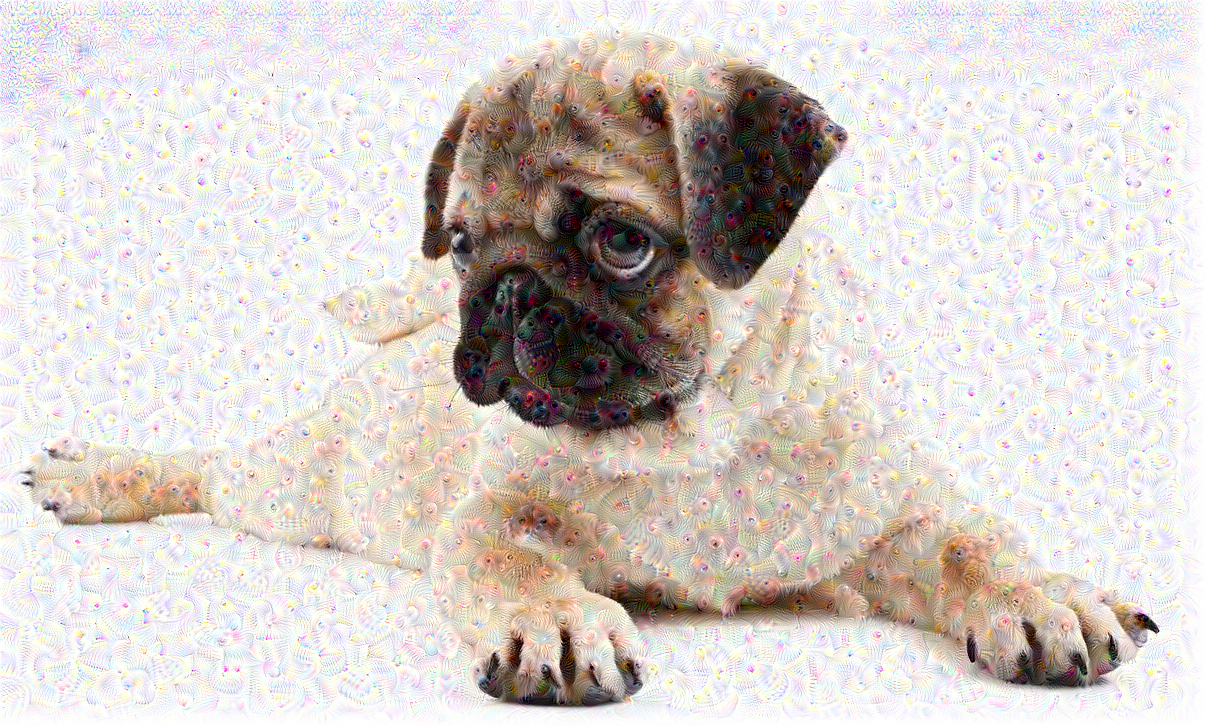

In [11]:
with tf.device('/device:GPU:0'):
    dream_img = run_deep_dream_simple(img=img_array, steps=100, step_size=0.01)